<a href="https://colab.research.google.com/github/alfanadhya/acne-detection-with-glcm-and-gabor/blob/main/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ipython-autotime
%load_ext autotime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 25.6 s (started: 2022-05-07 13:46:28 +00:00)


In [ ]:
# Libraries
from skimage.feature import greycomatrix, greycoprops
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from natsort import natsorted
from os.path import join
import cv2
import os
import xml.etree.ElementTree as ET

# For face landmark detection
import dlib
from imutils import face_utils
import argparse
import imutils

# To load model
import joblib

# Fo blob detection
from skimage.feature import blob_log

time: 3.48 s (started: 2022-05-07 13:46:53 +00:00)


In [ ]:
# KNN
# Load glcm model
glcm_model_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/knn_ycrcb_16.pkl'
glcm_model = joblib.load(glcm_model_path)

# Load glcm scaler
glcm_scaler_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/scaler_ycrcb_16.pkl'
glcm_scaler = joblib.load(glcm_scaler_path)

# Load gabor model
gabor_model_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/knn_gabor.pkl'
gabor_model = joblib.load(gabor_model_path)

# Load gabor scaler
gabor_scaler_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/scaler_knn_gabor.pkl'
gabor_scaler = joblib.load(gabor_scaler_path)

time: 405 ms (started: 2022-05-07 15:01:08 +00:00)


In [ ]:
# GMM
gmm_name = '/content/drive/MyDrive/DatasetTA_Playground/experiments/gmm_models/'

# Load glcm scaler
gmm_glcm_scaler_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/knn_models/scaler_grayscale.pkl'
gmm_glcm_scaler = joblib.load(gmm_glcm_scaler_path)

# glcm
acne_means = np.load(gmm_name + 'gmm_acne_means.npy')
acne_covar = np.load(gmm_name + 'gmm_acne_covariances.npy')
acne_gmm = GaussianMixture(n_components = len(acne_means), covariance_type='full')
acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(acne_covar))
acne_gmm.weights_ = np.load(gmm_name + 'gmm_acne_weights.npy')
acne_gmm.means_ = acne_means
acne_gmm.covariances_ = acne_covar

no_acne_means = np.load(gmm_name + 'gmm_no_acne_means.npy')
no_acne_covar = np.load(gmm_name + 'gmm_no_acne_covariances.npy')
no_acne_gmm = GaussianMixture(n_components = len(no_acne_means), covariance_type='full')
no_acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(no_acne_covar))
no_acne_gmm.weights_ = np.load(gmm_name + 'gmm_no_acne_weights.npy')
no_acne_gmm.means_ = no_acne_means
no_acne_gmm.covariances_ = no_acne_covar

# Load gabor scaler
gmm_gabor_scaler_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/gmm_models/scaler_gmm_gabor.pkl'
gmm_gabor_scaler = joblib.load(gmm_gabor_scaler_path)

# gabor
gabor_acne_means = np.load(gmm_name + 'gmm_gabor_acne_means.npy')
gabor_acne_covar = np.load(gmm_name + 'gmm_gabor_acne_covariances.npy')
gabor_acne_gmm = GaussianMixture(n_components = len(gabor_acne_means), covariance_type='full')
gabor_acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gabor_acne_covar))
gabor_acne_gmm.weights_ = np.load(gmm_name + 'gmm_gabor_acne_weights.npy')
gabor_acne_gmm.means_ = gabor_acne_means
gabor_acne_gmm.covariances_ = gabor_acne_covar

gabor_no_acne_means = np.load(gmm_name + 'gmm_gabor_no_acne_means.npy')
gabor_no_acne_covar = np.load(gmm_name + 'gmm_gabor_no_acne_covariances.npy')
gabor_no_acne_gmm = GaussianMixture(n_components = len(gabor_no_acne_means), covariance_type='full')
gabor_no_acne_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gabor_no_acne_covar))
gabor_no_acne_gmm.weights_ = np.load(gmm_name + 'gmm_gabor_no_acne_weights.npy')
gabor_no_acne_gmm.means_ = gabor_no_acne_means
gabor_no_acne_gmm.covariances_ = gabor_no_acne_covar

In [ ]:
# Load test images
test_file_path = '/content/drive/MyDrive/DatasetTA_Playground/test/all'

test_img_files = natsorted(glob.glob(join(test_file_path, '*.jpg')))
test_xml_files = natsorted(glob.glob(join(test_file_path, '*.xml')))

time: 666 ms (started: 2022-05-07 14:50:32 +00:00)


In [ ]:
def resize_img(img):
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  resized_img = cv2.resize(img, (320, 320), interpolation=cv2.INTER_NEAREST)

  return resized_img

time: 3.03 ms (started: 2022-05-07 14:50:35 +00:00)


In [ ]:
def skin_segmentation(img):
  img_cr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)[:,:,1]
  img_median = cv2.medianBlur(img_cr, 21)
  otsu_th, img_th = cv2.threshold(img_median, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  img_close = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel=np.ones((7,7),np.uint8), iterations=3)
  img_open = cv2.morphologyEx(img_close, cv2.MORPH_OPEN, kernel=np.ones((17,17),np.uint8), iterations = 3)

  mask_cr = cv2.cvtColor(img_open, cv2.COLOR_GRAY2RGB)
  output_cr = cv2.bitwise_and(mask_cr, img)

  return output_cr

time: 8.41 ms (started: 2022-05-07 14:50:38 +00:00)


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/DatasetTA_Playground/shape_predictor_68_face_landmarks.dat')

def mask_face_parts(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  rects = detector(gray, 0)
  colors = [(255,255,255),(255,255,255),(255,255,255),(255,255,255),(255,255,255),(255,255,255),(0,0,0),(0,0,0)] # exclude nose and jaw
  output_mask = np.zeros((img.shape[0], img.shape[1], 3))

  for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)
  
    part_area = face_utils.visualize_facial_landmarks(np.zeros((320,320)), shape, colors = colors, alpha=1)
    part_area = part_area.astype(np.uint8)
    part_area = cv2.dilate(part_area,kernel=np.ones((5,5),np.uint8),iterations = 1)

    part_mask = cv2.cvtColor(part_area, cv2.COLOR_GRAY2RGB)
    part_mask = 255 - part_mask
    mask = cv2.bitwise_and(part_mask, img)
    output_mask = mask

  return output_mask

time: 2.53 s (started: 2022-05-07 14:50:40 +00:00)


In [ ]:
def extract_acne_candidate(img):
  lab_img = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)[:,:,1]
  blurred_img = cv2.GaussianBlur(lab_img, (17, 17), 15, 15)
  dog_img = blurred_img - lab_img
  opening_img = cv2.morphologyEx(dog_img, cv2.MORPH_OPEN, kernel=np.ones((3,3),np.uint8))

  return opening_img

time: 3.05 ms (started: 2022-05-07 14:50:43 +00:00)


In [ ]:
def blob_detection(img):
  blobs = blob_log(img, min_sigma=1, max_sigma=5, num_sigma=15, threshold=.2, overlap=0.1)
  bbox_arr = np.zeros((len(blobs), 5))

  for c,blob in enumerate(blobs):
    y, x, r = blob
    bbox_arr[c,0] = int(x-7) if x > 10 else int(x)
    bbox_arr[c,1] = int(y-8) if y > 10 else int(y)
    bbox_arr[c,2] = int(x+8)
    bbox_arr[c,3] = int(y+9)
    bbox_arr[c,4] = r
  
  return bbox_arr,blobs

time: 6.92 ms (started: 2022-05-07 14:50:46 +00:00)


In [ ]:
def blob_detection_2(img):
  blobs = blob_log(img, min_sigma=1, max_sigma=5, num_sigma=15, threshold=.2, overlap=0.1)
  bbox_arr = np.zeros((len(blobs), 5))

  for c,blob in enumerate(blobs):
    y, x, r = blob
    bbox_arr[c,0] = int(x-(4*r)) if x > 10 else int(x)
    bbox_arr[c,1] = int(y-(4*r)) if y > 10 else int(y)
    bbox_arr[c,2] = int(x+(3*r))
    bbox_arr[c,3] = int(y+(4*r))
    bbox_arr[c,4] = r
  
  return bbox_arr,blobs

time: 7.52 ms (started: 2022-05-05 16:57:56 +00:00)


In [ ]:
def crop_blob(img, bbox_coors):
  cropped_img = []

  for i in range(len(bbox_coors)):
    xmin, ymin, xmax, ymax = int(bbox_coors[i,0]), int(bbox_coors[i,1]), int(bbox_coors[i,2]), int(bbox_coors[i,3])
    crop = img[ymin:ymax, xmin:xmax]
    cropped_img.append(crop)
  
  return cropped_img

time: 3.33 ms (started: 2022-05-07 14:50:51 +00:00)


In [ ]:
def get_glcm_features(cropped_img, scaler):
  feats_name = ['contrast', 'dissimilarity', 'correlation', 'energy', 'homogeneity', 'ASM']
  feats = np.zeros((len(cropped_img), len(feats_name)))

  for counter, block in enumerate(cropped_img):
    block = cv2.cvtColor(block, cv2.COLOR_RGB2YCrCb)[:,:,1]
    g = greycomatrix(block, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    feats[counter, 0] = np.mean(greycoprops(g, feats_name[0]))
    feats[counter, 1] = np.mean(greycoprops(g, feats_name[1]))
    feats[counter, 2] = np.mean(greycoprops(g, feats_name[2]))
    feats[counter, 3] = np.mean(greycoprops(g, feats_name[3]))
    feats[counter, 4] = np.mean(greycoprops(g, feats_name[4]))
    feats[counter, 5] = np.mean(greycoprops(g, feats_name[5]))
  
  feats_df = pd.DataFrame(feats, columns = feats_name)
  scale = scaler.transform(feats_df)
  scaled_df = pd.DataFrame(scale, columns=feats_name)

  return scaled_df

In [ ]:
def get_glcm_features_2(cropped_img, scaler):
  feats_name = ['contrast', 'correlation', 'energy', 'homogeneity']
  feats = np.zeros((len(cropped_img), len(feats_name)*4))
  degrees = [0, np.pi/4, np.pi/2, 3*np.pi/4]

  for counter, block in enumerate(cropped_img):
    block = cv2.cvtColor(block, cv2.COLOR_RGB2YCrCb)[:,:,1]
    g = greycomatrix(block, [1], degrees, normed=True, symmetric=True)
    temp = []
    for c, feat in enumerate(feats_name):
        preps = greycoprops(g, feats_name[c])
        preps = np.concatenate((preps))
        temp.append(preps)
    temp = np.concatenate(temp)
    feats[counter, :feats.shape[1]] = temp

  feats_df = pd.DataFrame(feats)
  scale = scaler.transform(feats_df)
  scaled_df = pd.DataFrame(scale)

  return scaled_df

time: 17 ms (started: 2022-05-07 15:01:43 +00:00)


In [ ]:
def get_gabor_features(cropped_img, scaler):
  thetas = (0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6)
  k_size = (3,3)
  sigma = 1
  psi = np.pi/2
  lambd = 0.8
  gamma = 0

  kernels = []
  for theta in thetas:
    kernel = cv2.getGaborKernel(ksize=k_size, sigma=sigma, theta=theta, lambd=lambd, gamma=gamma, psi=psi)
    kernels.append(kernel)

  feats = np.zeros((len(cropped_img), (len(kernels)*2)))
  feats_mean = np.zeros(len(kernels), dtype=np.double)
  feats_var = np.zeros(len(kernels), dtype=np.double)

  for counter, block in enumerate(cropped_img):
    block = cv2.cvtColor(block, cv2.COLOR_RGB2GRAY)
    #feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
      res = cv2.filter2D(block, ddepth=0, kernel=kernel)
      feats_mean[k] = res.mean()
      feats_var[k] = res.var()
    feats[counter, :feats.shape[1]] = np.concatenate((feats_mean, feats_var))

  feats_df = pd.DataFrame(feats)
  scale = scaler.transform(feats_df)
  scaled_df = pd.DataFrame(scale)
  
  return scaled_df

In [ ]:
def get_annotation_coor(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  objects = root.findall('object')
  obj_arr = np.zeros((len(objects), 4))

  for c,obj in enumerate(objects):
    xmin = int(obj.find('bndbox').find('xmin').text)
    ymin = int(obj.find('bndbox').find('ymin').text)
    xmax = int(obj.find('bndbox').find('xmax').text)
    ymax = int(obj.find('bndbox').find('ymax').text) 
    
    obj_arr[c,0] = xmin
    obj_arr[c,1] = ymin
    obj_arr[c,2] = xmax
    obj_arr[c,3] = ymax

  return obj_arr

time: 10.9 ms (started: 2022-05-07 14:52:55 +00:00)


In [ ]:
def non_max_suppression_slow(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# initialize the list of picked indexes
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
  # keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list, add the index
		# value to the list of picked indexes, then initialize
		# the suppression list (i.e. indexes that will be deleted)
		# using the last index
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		suppress = [last]

    # loop over all indexes in the indexes list
		for pos in range(0, last):
			# grab the current index
			j = idxs[pos]
			# find the largest (x, y) coordinates for the start of
			# the bounding box and the smallest (x, y) coordinates
			# for the end of the bounding box
			xx1 = max(x1[i], x1[j])
			yy1 = max(y1[i], y1[j])
			xx2 = min(x2[i], x2[j])
			yy2 = min(y2[i], y2[j])
			# compute the width and height of the bounding box
			w = max(0, xx2 - xx1 + 1)
			h = max(0, yy2 - yy1 + 1)
			# compute the ratio of overlap between the computed
			# bounding box and the bounding box in the area list
			overlap = float(w * h) / area[j]
			# if there is sufficient overlap, suppress the
			# current bounding box
			if overlap > overlapThresh:
				suppress.append(pos)
		# delete all indexes from the index list that are in the
		# suppression list
		idxs = np.delete(idxs, suppress)
	# return only the bounding boxes that were picked
	return boxes[pick]

time: 29.9 ms (started: 2022-05-07 14:52:56 +00:00)


In [ ]:
def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

time: 11.8 ms (started: 2022-05-07 14:53:00 +00:00)


In [ ]:
def hayashi_class(num_bbox):
  if num_bbox < 6:
    severity = 'MILD'
  elif num_bbox < 21:
    severity = 'MODERATE'
  elif num_bbox < 51:
    severity = 'SEVERE'
  else:
    severity = 'VERY SEVERE'
  
  return severity

time: 2.52 ms (started: 2022-05-07 14:53:03 +00:00)


Text(0.5, 0.98, '74 acne detected \n Class of acne severity: VERY SEVERE')

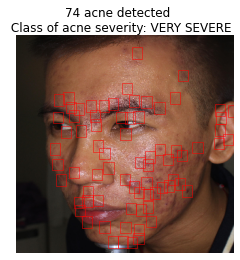

time: 3.84 s (started: 2022-05-07 16:11:05 +00:00)


In [ ]:
# KNN
idx = 19

test_img = resize_img(test_img_files[idx])
skin_img = skin_segmentation(test_img)
mask_face_img = mask_face_parts(skin_img)
roi_img = extract_acne_candidate(mask_face_img)
bboxes = blob_detection(roi_img)[0]
crops = crop_blob(test_img, bboxes)

features = get_glcm_features_2(crops, glcm_scaler)
pred_test = glcm_model.predict(features)

bboxes_true = []
for i,bbox in enumerate(bboxes):
  if pred_test[i] == 1:
    bboxes_true.append(bbox)

pick = non_max_suppression_slow(np.array(bboxes_true), 0.35)
severity = hayashi_class(len(pick))

# Show Detection Result
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
fig.suptitle(str(len(pick)) + ' acne detected \n Class of acne severity: ' + severity)

In [ ]:
# Evaluation
bboxes_gt = get_annotation_coor(test_xml_files[idx])
iou_calc = np.empty((len(bboxes_gt), len(pick)))

for i in range(len(bboxes_gt)):
    for j in range(len(pick)):
        iou_calc[i, j] = intersection_over_union(bboxes_gt[i], pick[j])

# make sure only one ground truth match one detection
iou_calc_max = np.empty((len(bboxes_gt), len(pick)))

for i, row in enumerate(iou_calc):
  row_max_idx = row.argmax()
  for c,el in enumerate(row):
    iou_calc_max[i,c] = el if c == row_max_idx else 0

for j, col in enumerate(iou_calc_max.T):
  col_max_idx = col.argmax()
  for c,el in enumerate(col):
    iou_calc_max[c,j] = el if c == col_max_idx else 0

row_max = []
for i, row in enumerate(iou_calc_max):
  row_max.append(row.max())

col_max = []
for j, col in enumerate(iou_calc_max.T):
  col_max.append(col.max())

fp = col_max.count(0) # wrong acne detection
fn = row_max.count(0) # undetected acne ground truth
tp = len(row_max) - fn # true acne detection

print(fp, fn, tp, len(bboxes_gt))
print(np.sum(col_max)/(len(col_max)-fp))

37 25 37 62
0.4496414624052031
time: 73.2 ms (started: 2022-05-07 16:11:09 +00:00)


In [ ]:
'''# GMM

idx = 19

test_img = resize_img(test_img_files[idx])
skin_img = skin_segmentation(test_img)
mask_face_img = mask_face_parts(skin_img)
roi_img = extract_acne_candidate(mask_face_img)
bboxes = blob_detection(roi_img)[0]
crops = crop_blob(test_img, bboxes)

features = get_gabor_features(crops, gmm_gabor_scaler)
features = features.to_numpy()
scores = []
for feature in features:
  proc_image = np.reshape(feature, (1, -1))
  no_acne_score = gabor_no_acne_gmm.score_samples(proc_image)
  acne_score = gabor_acne_gmm.score_samples(proc_image)
  res = acne_score > no_acne_score
  scores.append(res*1)
pred_test = np.concatenate(scores)

bboxes_true = []
for i,bbox in enumerate(bboxes):
  if pred_test[i] == 1:
    bboxes_true.append(bbox)

pick = non_max_suppression_slow(np.array(bboxes_true), 0.35)
severity = hayashi_class(len(pick))

# Show Detection Result
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
fig.suptitle(str(len(pick)) + ' acne detected \n Class of acne severity: ' + severity)'''

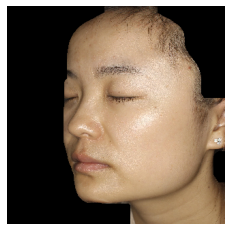

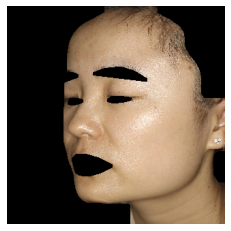

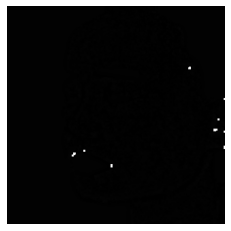

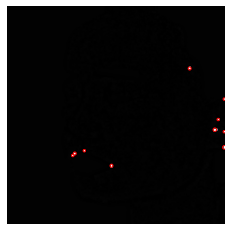

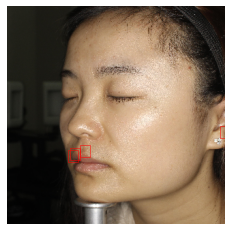

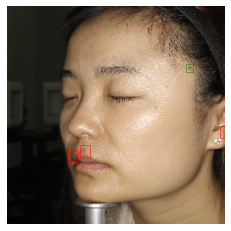

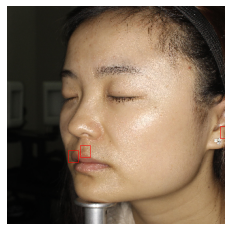

time: 1.85 s (started: 2022-05-06 03:27:01 +00:00)


In [ ]:
res_path = '/content/drive/MyDrive/DatasetTA_Playground/experiments/detection_results/gmm_gabor_uniform_bbox/'

# System Output
bx.figure.savefig(res_path + 'system_output_' + str(idx) + '.jpg',bbox_inches='tight')

# Skin Segmentation
plt.imshow(skin_img)
plt.axis('Off')
plt.savefig(res_path + 'skin_segmentation_' + str(idx) + '.jpg', bbox_inches='tight')
plt.show()

# Face Parts Masking
plt.imshow(mask_face_img)
plt.axis('Off')
plt.savefig(res_path + 'face_part_masking_' + str(idx) + '.jpg', bbox_inches='tight')
plt.show()

# Acne Candidates
plt.imshow(roi_img, cmap='gray')
plt.axis('Off')
plt.savefig(res_path + 'acne_candidates_' + str(idx) + '.jpg', bbox_inches='tight')
plt.show()

# Blob Detection
blobs = blob_detection(roi_img)[1]
fig, ax = plt.subplots()
ax.imshow(roi_img, cmap='gray')
ax.set_axis_off()
for blob in blobs:
    y, x, r = blob
    ax.add_patch(plt.Circle((x, y), r*np.sqrt(2), color='r', linewidth=1, fill=False))
ax.figure.savefig(res_path + 'blob_detection_' + str(idx) + '.jpg',bbox_inches='tight')

# Original Result
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
real = np.array(bboxes_true)
for i in range(len(real)):
  bx.add_patch(plt.Rectangle((real[i,0], real[i,1]), real[i,2]-real[i,0], real[i,3]-real[i,1], color='r', linewidth=.5, fill=False))
bx.figure.savefig(res_path + 'ori_result_' + str(idx) + '.jpg',bbox_inches='tight')

# Non Maximum Suppression
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
for i in range(len(bboxes_gt)):  
  bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=False))
bx.figure.savefig(res_path + 'nms_' + str(idx) + '.jpg',bbox_inches='tight')

# Remove doubles
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
for i in range(len(bboxes_gt)):      
  if not row_max[i]==0:
    bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=False))
bx.figure.savefig(res_path + 'rmv_doubles_' + str(idx) + '.jpg',bbox_inches='tight')

In [ ]:
print(len(iou_calc),len(pick), len(bboxes_gt), len(bboxes_true))
print(len(iou_calc)/len(pick))
print(len(pick)/len(bboxes_gt))

1 3 1 4
0.3333333333333333
3.0
time: 9.77 ms (started: 2022-05-06 03:27:03 +00:00)


## Bbox Size Trials

In [ ]:
'''idx = 15

test_img = resize_img(test_img_files[idx])
skin_img = skin_segmentation(test_img)
mask_face_img = mask_face_parts(skin_img)
roi_img = extract_acne_candidate(mask_face_img)
bboxes = blob_detection_2(roi_img)[0]
crops = crop_blob(test_img, bboxes)

features = get_glcm_features(crops, glcm_scaler)
pred_test = glcm_model.predict(features)

bboxes_true = []
for i,bbox in enumerate(bboxes):
  if pred_test[i] == 1:
    bboxes_true.append(bbox)

pick = non_max_suppression_slow(np.array(bboxes_true), 0.35)
severity = hayashi_class(len(pick))

# Show Detection Result
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
fig.suptitle(str(len(pick)) + ' acne detected \n Class of acne severity: ' + severity)'''

"idx = 15\n\ntest_img = resize_img(test_img_files[idx])\nskin_img = skin_segmentation(test_img)\nmask_face_img = mask_face_parts(skin_img)\nroi_img = extract_acne_candidate(mask_face_img)\nbboxes = blob_detection_2(roi_img)[0]\ncrops = crop_blob(test_img, bboxes)\n\nfeatures = get_glcm_features(crops, glcm_scaler)\npred_test = glcm_model.predict(features)\n\nbboxes_true = []\nfor i,bbox in enumerate(bboxes):\n  if pred_test[i] == 1:\n    bboxes_true.append(bbox)\n\npick = non_max_suppression_slow(np.array(bboxes_true), 0.35)\nseverity = hayashi_class(len(pick))\n\n# Show Detection Result\nfig, bx = plt.subplots()\nbx.imshow(test_img)\nbx.axis('Off')\nfor i in range(len(pick)):\n  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))\nfig.suptitle(str(len(pick)) + ' acne detected \n Class of acne severity: ' + severity)"

time: 10.3 ms (started: 2022-05-06 03:27:03 +00:00)


In [ ]:
'''# Evaluation
bboxes_gt = get_annotation_coor(test_xml_files[idx])
iou_calc = np.empty((len(bboxes_gt), len(pick)))

for i in range(len(bboxes_gt)):
    for j in range(len(pick)):
        iou_calc[i, j] = intersection_over_union(bboxes_gt[i], pick[j])

# make sure only one ground truth match one detection
iou_calc_max = np.empty((len(bboxes_gt), len(pick)))

for i, row in enumerate(iou_calc):
  row_max_idx = row.argmax()
  for c,el in enumerate(row):
    iou_calc_max[i,c] = el if c == row_max_idx else 0

for j, col in enumerate(iou_calc_max.T):
  col_max_idx = col.argmax()
  for c,el in enumerate(col):
    iou_calc_max[c,j] = el if c == col_max_idx else 0

row_max = []
for i, row in enumerate(iou_calc_max):
  row_max.append(row.max())

col_max = []
for j, col in enumerate(iou_calc_max.T):
  col_max.append(col.max())

fp = col_max.count(0) # wrong acne detection
fn = row_max.count(0) # undetected acne ground truth
tp = len(row_max) - fn # true acne detection

print(fp, fn, tp)
print(np.sum(col_max)/(len(col_max)-fp))'''

'# Evaluation\nbboxes_gt = get_annotation_coor(test_xml_files[idx])\niou_calc = np.empty((len(bboxes_gt), len(pick)))\n\nfor i in range(len(bboxes_gt)):\n    for j in range(len(pick)):\n        iou_calc[i, j] = intersection_over_union(bboxes_gt[i], pick[j])\n\n# make sure only one ground truth match one detection\niou_calc_max = np.empty((len(bboxes_gt), len(pick)))\n\nfor i, row in enumerate(iou_calc):\n  row_max_idx = row.argmax()\n  for c,el in enumerate(row):\n    iou_calc_max[i,c] = el if c == row_max_idx else 0\n\nfor j, col in enumerate(iou_calc_max.T):\n  col_max_idx = col.argmax()\n  for c,el in enumerate(col):\n    iou_calc_max[c,j] = el if c == col_max_idx else 0\n\nrow_max = []\nfor i, row in enumerate(iou_calc_max):\n  row_max.append(row.max())\n\ncol_max = []\nfor j, col in enumerate(iou_calc_max.T):\n  col_max.append(col.max())\n\nfp = col_max.count(0) # wrong acne detection\nfn = row_max.count(0) # undetected acne ground truth\ntp = len(row_max) - fn # true acne detecti

time: 11.2 ms (started: 2022-05-06 03:27:03 +00:00)


In [ ]:
'''# Non Maximum Suppression
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
for i in range(len(bboxes_gt)):  
  bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=False))
#bx.figure.savefig(res_path + 'nms_' + str(idx) + '.jpg',bbox_inches='tight')

# Remove doubles
fig, bx = plt.subplots()
bx.imshow(test_img)
bx.axis('Off')
for i in range(len(pick)):
  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))
for i in range(len(bboxes_gt)):      
  if not row_max[i]==0:
    bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=False))
#bx.figure.savefig(res_path + 'rmv_doubles_' + str(idx) + '.jpg',bbox_inches='tight')'''

"# Non Maximum Suppression\nfig, bx = plt.subplots()\nbx.imshow(test_img)\nbx.axis('Off')\nfor i in range(len(pick)):\n  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))\nfor i in range(len(bboxes_gt)):  \n  bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=False))\n#bx.figure.savefig(res_path + 'nms_' + str(idx) + '.jpg',bbox_inches='tight')\n\n# Remove doubles\nfig, bx = plt.subplots()\nbx.imshow(test_img)\nbx.axis('Off')\nfor i in range(len(pick)):\n  bx.add_patch(plt.Rectangle((pick[i,0], pick[i,1]), pick[i,2]-pick[i,0], pick[i,3]-pick[i,1], color='r', linewidth=.5, fill=False))\nfor i in range(len(bboxes_gt)):      \n  if not row_max[i]==0:\n    bx.add_patch(plt.Rectangle((bboxes_gt[i,0], bboxes_gt[i,1]), bboxes_gt[i,2]-bboxes_gt[i,0], bboxes_gt[i,3]-bboxes_gt[i,1], color='g', linewidth=.5, fill=Fal

time: 6.4 ms (started: 2022-05-06 03:27:03 +00:00)


In [ ]:
'''
widths = bboxes_gt[:,2]-bboxes_gt[:,0]
heights = bboxes_gt[:,3]-bboxes_gt[:,1]
w = []
h = []
for c, col in enumerate(iou_calc_max.T):
  arr_idx = np.argmax(col)
  if not arr_idx == 0:
    r = widths[arr_idx] / pick[c,-1]
    w.append(r)
    r = heights[arr_idx] / pick[c,-1]
    h.append(r)
'''

'\nwidths = bboxes_gt[:,2]-bboxes_gt[:,0]\nheights = bboxes_gt[:,3]-bboxes_gt[:,1]\nw = []\nh = []\nfor c, col in enumerate(iou_calc_max.T):\n  arr_idx = np.argmax(col)\n  if not arr_idx == 0:\n    r = widths[arr_idx] / pick[c,-1]\n    w.append(r)\n    r = heights[arr_idx] / pick[c,-1]\n    h.append(r)\n'

time: 5.01 ms (started: 2022-05-06 03:27:03 +00:00)
